In [1]:
# EpiBERT Gradients and Gene Analysis Workflow
# This notebook demonstrates a complete workflow for analyzing model gradients and gene predictions
# using EpiBERT. It covers:
# 1. Model gradient analysis for single genomic intervals
# 2. Batch predictions for multiple genes
# 3. Parsing and evaluating predictions

import sys
import os
import subprocess
import warnings
from pathlib import Path
import random
import time
from datetime import datetime
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow_addons')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Core imports
import tensorflow as tf
from tensorflow.keras import mixed_precision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# EpiBERT imports (using refactored modules)
import epibert.models.epibert_rampage_finetune as epibert
from epibert.analysis import interval_plotting_consolidated as utils

gpus = tf.config.experimental.list_physical_devices('GPU') # using an A100 40GB since gradient computation is so memory intense
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
mixed_precision.set_global_policy('mixed_bfloat16')

In [2]:
# Configuration - Update these paths for your environment
# Model parameters
SEQUENCE_LENGTH = 524288
RESOLUTION = 4
NUM_BINS = SEQUENCE_LENGTH // RESOLUTION
OUTPUT_LENGTH = NUM_BINS // 32
CROP_SIZE = 1600 # want to keep the center 896 for RAMPAGE intervals 
MASK_INDICES = '2041-2053' # covers 128 * 12 bases 

fasta_file = '/home/jupyter/EpiBERT/example_usage/hg38_erccpatch.fa'
atac_file = "K562.adjust.bed.gz" # create your own in data_processing.ipynb or download an example from gs://epibert/example_data
rna_file = "HG_K562.rampage.bed.gz" # bed formatted RAMPAGE file, get an example from gs://epibert/example_data/HG_K562.rampage.bed.gz. 
# make sure you have a tabix index available for both files 
tf_file = 'ENCFF135AEX.motifs.tsv'
enhancer_file = '/home/jupyter/datasets/eg/hg38_eg.bed'

# Model checkpoint path
checkpoint_path = "fine_tuned/ckpt-16"
# Output directories
temp_dir = "temp_files"
output_dir = "output_gradients"

# Create output directories if they don't exist
os.makedirs(temp_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Gene dictionary for analysis
GENES_DICT = {
    "HNRNPA1": "chr12:54279939-54281439",
    "NFE2": "chr12:54300287-54301787", 
    "COPZ1": "chr12:54324339-54325839",
    "ITGA5": "chr12:54418516-54420016",
    "WDR83OS": "chr19:12668901-12670401",
    "DHPS": "chr19:12681137-12682637",
    "C19orf43": "chr19:12734025-12735525",
    "JUNB": "chr19:12790745-12792245",
    "PRDX2": "chr19:12801160-12802660",
    "RNASEH2A": "chr19:12805863-12807363",
    "MYC": "chr8:127735318-127736818",
    "GATA1": "chrX:48785823-48787323"
}

# Set random seed for reproducibility
seed = 6
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Initialize Model and Data Extractors

#  FASTA extractor
fasta_extractor = utils.FastaStringExtractor(fasta_file)

gpus = tf.config.experimental.list_physical_devices('GPU')

# Initialize model with GPU strategy

# Load EpiBERT models
model = epibert.epibert_rampage_finetune()

# Create ensemble model wrapper
epibert_model = utils.epibert_rampage_model_gpu(model, checkpoint_path)
print("EpiBERT models loaded successfully")

Building model with dummy input...
Model variables created
Model weights loaded
EpiBERT models loaded successfully


In [4]:
# Single Interval Analysis - HNRNPA1 Example

# Select a specific genomic interval for detailed analysis
example_gene = "HNRNPA1"
interval = GENES_DICT[example_gene]

print(f"Analyzing interval: {example_gene} at {interval}")

# Extract inputs for the genomic interval
print("Extracting inputs for interval analysis...")
inputs, masked_atac, target_atac, target_atac_uncropped, rna_arr, masked_atac_reshape, mask, mask_centered = \
    utils.return_all_inputs_simple_gpu(
        interval, 
        atac_file, 
        rna_file, 
        SEQUENCE_LENGTH,
        NUM_BINS, 
        RESOLUTION, 
        tf_file, 
        CROP_SIZE, 
        OUTPUT_LENGTH,
        fasta_extractor, 
        MASK_INDICES
    )

print(f" Inputs extracted:")
print(f"  - Sequence shape: {inputs[0].shape}")
print(f"  - atac shape: {inputs[1].shape}")
print(f"  - motif shape: {inputs[2].shape}")
print(f"  - ATAC shape: {masked_atac.shape}")
print(f"  - RNA shape: {rna_arr.shape}")
print(f"  - Target ATAC shape: {target_atac.shape}")

# Compute gradients using integrated gradients
print("Computing gradients...")
# Use GPU if available, otherwise CPU
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    seq, seq_grads, atac_grads, prediction, att_matrices = \
        epibert_model.contribution_input_grad_dist_simple(inputs, mask)

print(f"Gradients computed:")
print(f"  - Sequence gradients shape: {seq_grads.shape}")
print(f"  - ATAC gradients shape: {atac_grads.shape}")
print(f"  - Prediction shape: {prediction.shape}")


Analyzing interval: HNRNPA1 at chr12:54279939-54281439
Extracting inputs for interval analysis...
 Inputs extracted:
  - Sequence shape: (1, 524288, 4)
  - atac shape: (1, 131072, 1)
  - motif shape: (1, 1, 693)
  - ATAC shape: (131072, 1)
  - RNA shape: (896, 1)
  - Target ATAC shape: (896, 1)
Computing gradients...
Using device: /GPU:0
Gradients computed:
  - Sequence gradients shape: (1, 524288, 4)
  - ATAC gradients shape: (131072, 1)
  - Prediction shape: (1, 896, 1)


Creating prediction comparison plot...


<Figure size 1500x600 with 0 Axes>

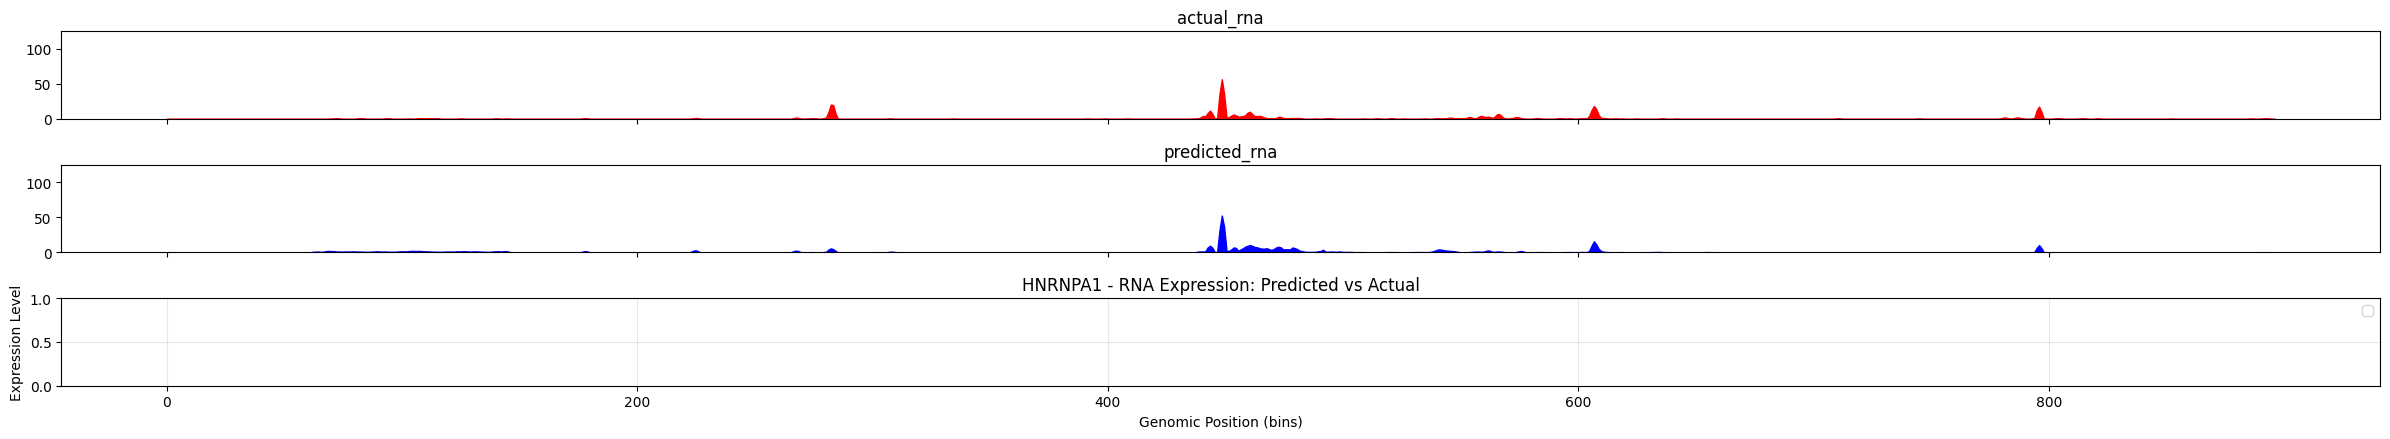

Pearson correlation (predicted vs actual): 0.919


In [5]:
# Visualize Predictions vs Ground Truth

print("Creating prediction comparison plot...")

# Plot predicted vs actual RNA expression
tracks = {
    'actual_rna': (rna_arr[:, 0], 'red'),
    'predicted_rna': (prediction[0, :, 0], 'blue')
}

plt.figure(figsize=(15, 6))
utils.plot_tracks(tracks, 0, 896, 125)
plt.title(f'{example_gene} - RNA Expression: Predicted vs Actual')
plt.xlabel('Genomic Position (bins)')
plt.ylabel('Expression Level')
plt.legend(['Actual RNA', 'Predicted RNA'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between predicted and actual
correlation = pearsonr(rna_arr[:, 0].numpy(), prediction[0, :, 0].numpy())[0]
print(f"Pearson correlation (predicted vs actual): {correlation:.3f}")


In [6]:
print("Processing gradients and enhancer annotations...")

# Process ATAC gradients
grad_input = tf.abs(atac_grads[:, 0]) * masked_atac[:, 0]
reshaped_grad = tf.reduce_sum(tf.reshape(grad_input, [4096, 32]), axis=1)

# Process sequence gradients
seq_grad_input = tf.reduce_sum(
    tf.reshape(
        tf.reduce_sum(tf.abs(seq_grads[0,:,:]) * seq[0, :, :], axis=1),
        [-1, 128]
    ),
    axis=1
)

# write out parsed ABC results for our HRNPA1 
# need tabix, bgzip installed here
utils.process_enhancer_annotations(example_gene,os.getcwd(), input_file='hg38_eg.bed')

enhancer_file = f'{example_gene}.eg.encoded.bed.gz'
eg = utils.return_eg(interval, enhancer_file, SEQUENCE_LENGTH)
eg_grouped = tf.reduce_max(tf.reshape(eg, [4096, 128]), axis=1)

# Load significance annotations
sig_file = f'{example_gene}.eg.sig.encoded.bed.gz'
eg_sig = utils.return_eg(interval, sig_file, SEQUENCE_LENGTH)
eg_grouped_sig = tf.reduce_max(tf.reshape(eg_sig, [4096, 128]), axis=1)


# Normalize gradients for visualization
atac_grads_norm = reshaped_grad / tf.reduce_max(reshaped_grad)
seq_grads_norm = seq_grad_input / tf.reduce_max(seq_grad_input)
atac_signal_norm = target_atac_uncropped[:, 0] / tf.reduce_max(target_atac_uncropped[:, 0])


Processing gradients and enhancer annotations...
/home/jupyter/repos/EpiBERT/example_usage/HNRNPA1.eg.encoded.bed
/home/jupyter/repos/EpiBERT/example_usage/HNRNPA1.eg.sig.encoded.bed
Processed 84 enhancers for HNRNPA1
Found 5 significant enhancers


<Figure size 2000x1200 with 0 Axes>

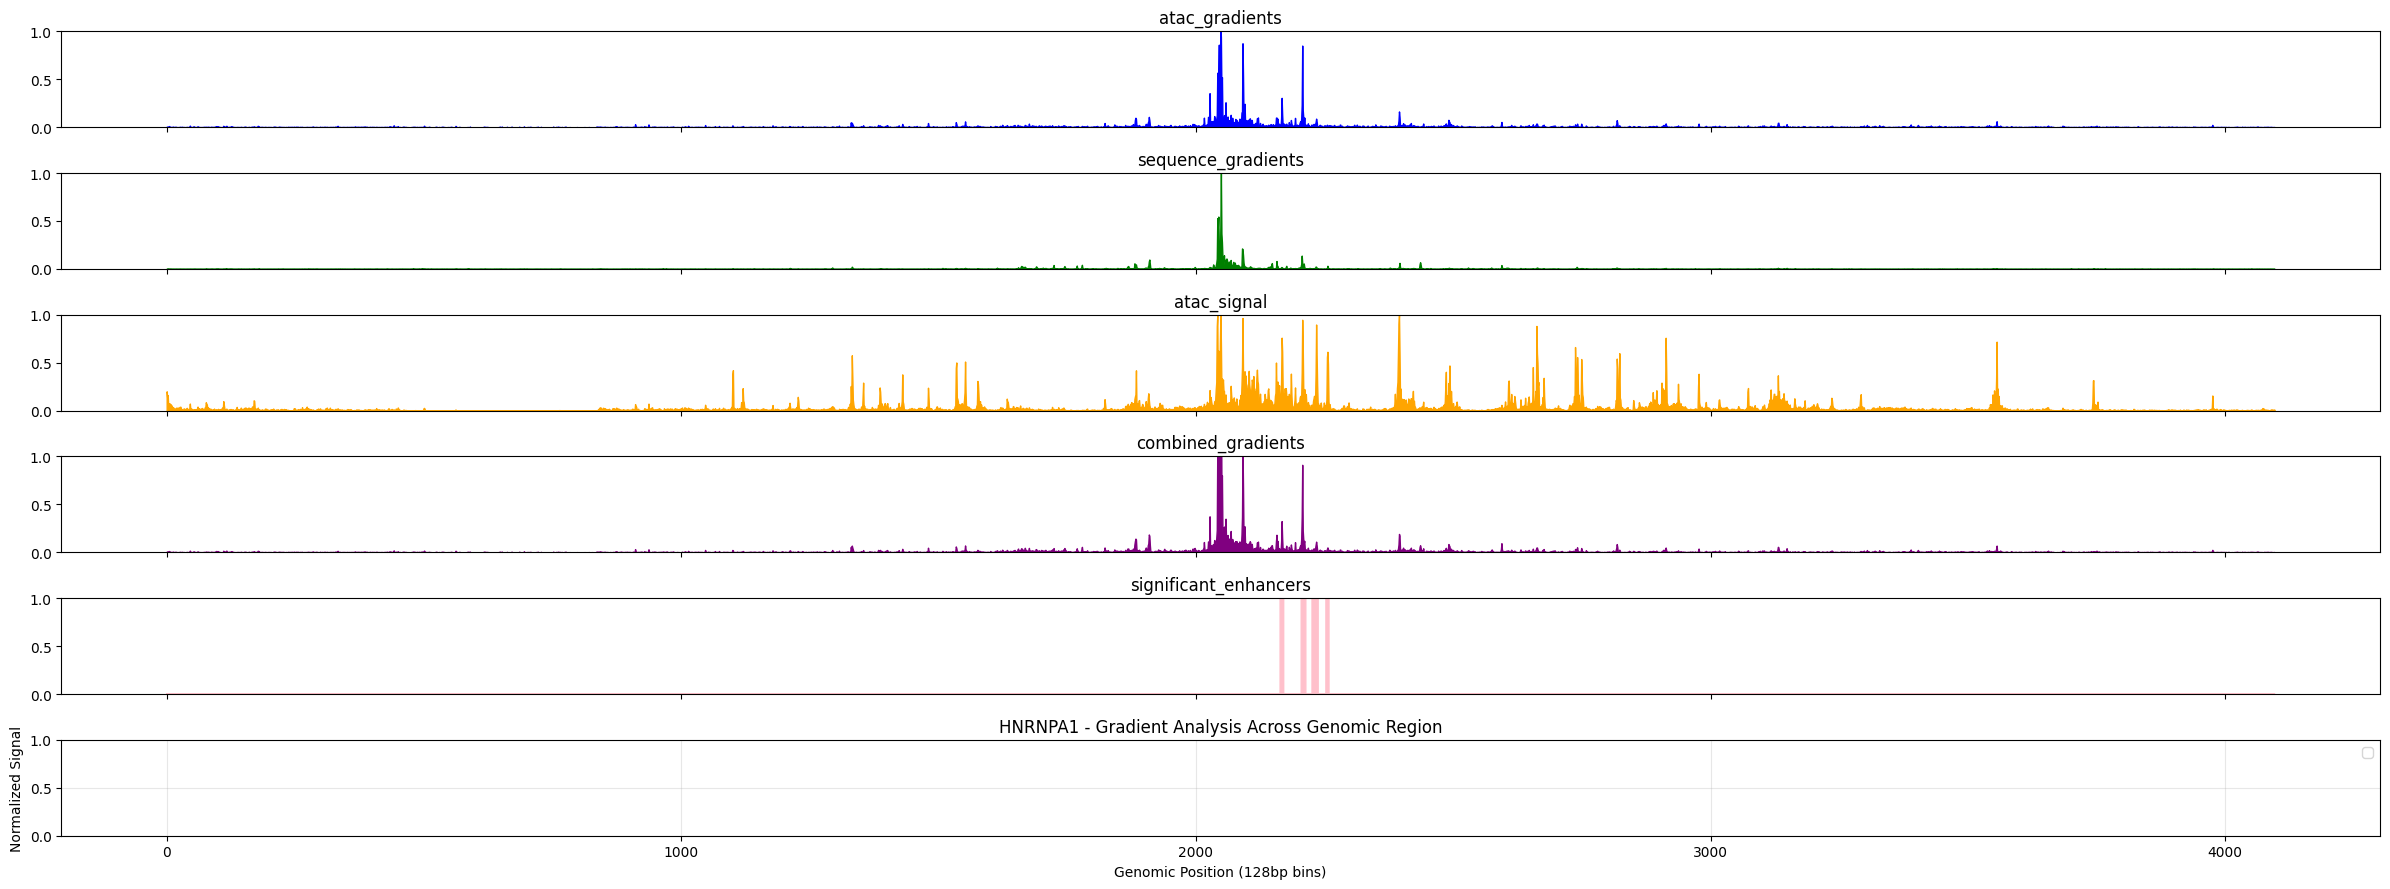

✓ Gradient visualization completed


In [7]:
# Create Comprehensive Gradient Visualization
# ==========================================

tracks = {
    'atac_gradients': (atac_grads_norm, 'blue'),
    'sequence_gradients': (seq_grads_norm, 'green'),
    'atac_signal': (atac_signal_norm, 'orange'),
    'combined_gradients': (atac_grads_norm + seq_grads_norm, 'purple'),
    'significant_enhancers': (eg_grouped_sig, 'pink')
}


# Create the plot
plt.figure(figsize=(20, 12))
utils.plot_tracks(tracks, 0, 4096, 1.0)
plt.title(f'{example_gene} - Gradient Analysis Across Genomic Region')
plt.xlabel('Genomic Position (128bp bins)')
plt.ylabel('Normalized Signal')

# Create legend
legend_labels = [
    'ATAC Gradients',
    'Sequence Gradients', 
    'ATAC Signal',
    'Combined Gradients',
    'Validated enhancers'
]

plt.legend(legend_labels, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Gradient visualization completed")
